<a href="https://colab.research.google.com/github/alihussainia/openvino-colab/blob/master/detailed_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drive Mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model Work

### fastai Installation

In [10]:
#install fastai
!pip install fastai

In [12]:
from fastai.vision import *
from fastai.metrics import error_rate
bs = 64

### Data Downloading & Organization

In [13]:
!wget  --backups=1 -q https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
!wget  --backups=1 -q https://ceb.nlm.nih.gov/proj/malaria#/malaria_cell_classification_code.zip
# List what you've downloaded:
!ls -al

total 345196
drwxr-xr-x 1 root root      4096 Nov 11 13:15 .
drwxr-xr-x 1 root root      4096 Nov 11 13:07 ..
-rw-r--r-- 1 root root 353452851 Apr  6  2018 cell_images.zip
drwxr-xr-x 1 root root      4096 Nov  6 17:30 .config
drwx------ 5 root root      4096 Nov 11 13:08 drive
drwxr-xr-x 1 root root      4096 Nov  6 17:30 sample_data


In [14]:
!unzip cell_images.zip

Streaming output truncated to the last 5000 lines.
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_91.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_1

In [15]:
!mv cell_images train
!mkdir data
!mv train data

### Data Preprocessing

In [16]:
path = Path("./data")

In [17]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=128, valid_pct=0.2, bs=64).normalize(imagenet_stats)

### fastai Network Creation & Training

In [18]:
# create a fastai network for transfer learning
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  # Cell
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [19]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.270841,0.174711,0.066050,01:33
1,0.197856,0.144984,0.050445,01:30
2,0.168140,0.129810,0.046453,01:26
3,0.165166,0.124247,0.045545,01:24


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

### fastai to ONNX Conversion

In [20]:
# save model to Onnx format
import torch
import torchvision

dummy_input = torch.randn(1, 3, 128, 128, device='cuda')
onnx_path =  "/content/model_fastai.onnx"

torch.onnx.export(learn.model, dummy_input, onnx_path, verbose=False)
print('Model exported to ' + onnx_path)

Model exported to /content/model_fastai.onnx


In [21]:
#retrieve the activation function used to reproduce the same actiavtion after
# network ouput
from fastai import basic_train
print(basic_train._loss_func2activ(learn.loss_func))

#create labels file
with open("blood.classes", 'w') as dc:
  dc.write('\n'.join(data.classes))
  
# export the stats to normalize the image
with open('/content/norm.txt', 'w') as fd:
  fd.write(repr(imagenet_stats))

functools.partial(<function softmax at 0x7f3bcc059e18>, dim=-1)


### Data Visualization

In [22]:
images_path = get_image_files(path, recurse=True)[0:4]
images_path

[PosixPath('data/train/Parasitized/C117P78ThinF_IMG_20150930_214511_cell_96.png'),
 PosixPath('data/train/Parasitized/C48P9thinF_IMG_20150721_161412_cell_186.png'),
 PosixPath('data/train/Parasitized/C133P94ThinF_IMG_20151004_154512_cell_144.png'),
 PosixPath('data/train/Parasitized/C59P20thinF_IMG_20150803_111244_cell_203.png')]

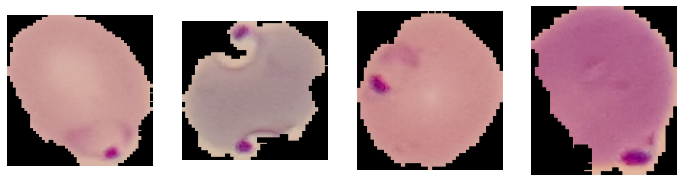

In [23]:
images = [open_image(i) for i in images_path]
show_all(images)

### fastai based inference

In [24]:
for i, im in enumerate(images):
  p = learn.predict(im)
  print(images_path[i], p[0], p[2][p[1]].item())

data/train/Parasitized/C117P78ThinF_IMG_20150930_214511_cell_96.png Parasitized 0.9460728168487549
data/train/Parasitized/C48P9thinF_IMG_20150721_161412_cell_186.png Parasitized 0.99434894323349
data/train/Parasitized/C133P94ThinF_IMG_20151004_154512_cell_144.png Parasitized 0.9943128824234009
data/train/Parasitized/C59P20thinF_IMG_20150803_111244_cell_203.png Parasitized 0.9945207834243774


# OpenVINO Installation & Operations


### Reference: [openvino-colab](https://github.com/alihussainia/openvino-colab)

In [25]:
!pip install openvino-colab

  Created wheel for openvino-colab: filename=openvino_colab-3.0.0-cp36-none-any.whl size=3650 sha256=524369ea1e9b2aa18cf837e93b2925414ac6ccec51260f9845f84a101a5c346f
  Stored in directory: /root/.cache/pip/wheels/05/01/a0/dfa8ef7464c8d79473d638e0988a5199d6bd5d131c60afb643
Successfully built openvino-colab


In [26]:
import openvino_colab

Installed OpenVINO Dependencies. Installing OpenVINO...
ENV Variables Set!
Please enter the Choice of framework you want to work with:

(Note: You should only install for the ones you would be using.
Incase of needing to install for more than one but not all, rerun this cell and 
install the pre-requisites one by one.)

1 tf
2 mxnet
3 onnx
4 kaldi
5 all
Please enter your choice (Default Option - 5): 3
Choice is 3.0 : onnx


Intel OpenVINO Installation Fisnished!


In [27]:
install_dir = "/opt/intel/openvino/"
model_optimizer = "/opt/intel/openvino/deployment_tools/model_optimizer/"
deployment_tools = "/opt/intel/openvino/deployment_tools/"
model_zoo = '/opt/intel/openvino/deployment_tools/open_model_zoo/'

### Intermediate Representation

In [28]:
!pip install onnx=='1.1.2'

     |████████████████████████████████| 3.6MB 4.2MB/s 
  Found existing installation: onnx 1.8.0
    Uninstalling onnx-1.8.0:
      Successfully uninstalled onnx-1.8.0


In [29]:
# create the Intermediate Representation and run inference on the CPU
!source /opt/intel/openvino/bin/setupvars.sh &&\
python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
   --input_model model_fastai.onnx --output_dir ir --data_type FP32

[setupvars.sh] OpenVINO environment initialized
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/content/model_fastai.onnx
	- Path for generated IR: 	/content/ir
	- IR output name: 	model_fastai
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
ONNX specific parameters:
Model Optimizer version: 	2020.1.0-61-gd349c3ba4a

[ SUCCESS ] Generated IR version 10 model.
[ SUCCESS ] XML file: /content/ir/model_fastai.xml
[ SUCCESS ] BIN file: /content/ir/model_fastai.bin
[ SUCCESS ] Total execution time: 5

### Infer.py 

In [30]:
!cat ./norm.txt

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [31]:
# generated a python file (to be able to run it as a script with OpenVINO environment
s = r"""
import sys
import os
from argparse import ArgumentParser
import cv2
import numpy as np
import logging as log
from time import time
from openvino.inference_engine import IENetwork, IEPlugin
import math

# here put the values from the norm.txt file

resnet_mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
resnet_scale = np.array([0.229, 0.224, 0.225], dtype=np.float32)


def preprocess(im, h, w):
    assert(h == w == 128)
    sz = 128
    # convert image to [0-1] RGB, Width Height Channel
    im = im.astype(np.float32) / 255
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    # resize and crop center
    r,c, *_ = im.shape
    ratio = sz / min(r, c)
    im = cv2.resize(im, 
                    (max(math.floor(c * ratio), sz), max(math.floor(r * ratio), sz)),
                    interpolation=cv2.INTER_AREA)
    startx = math.ceil((im.shape[0] - sz) / 2)
    starty = math.ceil((im.shape[1] - sz) / 2)
    im = im[startx:startx + sz, starty:starty + sz]

    # normalize and convert to Channel Width Height
    im = (im - resnet_mean) / resnet_scale
    im = im.transpose((2, 0, 1))
    return im


parser = ArgumentParser()
parser.add_argument("-m", "--model", help="Path to an .xml file with a trained model.", required=True, type=str)
parser.add_argument("-i", "--input", help="Path to a folder with images or path to an image files", required=True,
                    type=str, nargs="+")
parser.add_argument("-d", "--device",
                    help="Specify the target device to infer on; CPU, GPU, FPGA or MYRIAD is acceptable. Sample "
                         "will look for a suitable plugin for device specified (CPU by default)", default="CPU",
                    type=str)
parser.add_argument("--labels", help="Labels mapping file", default=None, type=str)
parser.add_argument("-nt", "--number_top", help="Number of top results", default=10, type=int)


log.basicConfig(format="[ %(levelname)s ] %(message)s", level=log.INFO, stream=sys.stdout)
args = parser.parse_args()
model_xml = args.model
model_bin = os.path.splitext(model_xml)[0] + ".bin"

# Plugin initialization for specified device and load extensions library if specified
plugin = IEPlugin(device=args.device)
# Read IR
log.info("Loading network files:\n\t{}\n\t{}".format(model_xml, model_bin))
net = IENetwork(model=model_xml, weights=model_bin)

assert len(net.inputs.keys()) == 1, "Sample supports only single input topologies"
assert len(net.outputs) == 1, "Sample supports only single output topologies"

log.info("Preparing input blobs")
input_blob = next(iter(net.inputs))
out_blob = next(iter(net.outputs))
net.batch_size = len(args.input)

# Read and pre-process input images
n, c, h, w = net.inputs[input_blob].shape
images = np.ndarray(shape=(n, c, h, w))
for i in range(n):
    image = cv2.imread(args.input[i])
    image = preprocess(image, h, w)
    images[i] = image

log.info("Loading model to the plugin")
exec_net = plugin.load(network=net)
del net

log.info("Starting inference)")
res = exec_net.infer(inputs={input_blob: images})

log.info("Processing output blob")
res = res[out_blob]
log.info("Top {} results: ".format(args.number_top))
if args.labels:
    with open(args.labels, 'r') as f:
        labels_map = [x.split(sep=' ', maxsplit=1)[-1].strip() for x in f]
else:
    labels_map = None
for i, probs in enumerate(res):
    probs = np.squeeze(probs)
    
    #### add the softmax layer manually
    probs = np.exp(probs)/sum(np.exp(probs))
    ####
    
    top_ind = np.argsort(probs)[-args.number_top:][::-1]
    print("Image {}".format(args.input[i]))
    for id in top_ind:
        det_label = labels_map[id] if labels_map else "#{}".format(id)
        print("{:.7f} label {}".format(probs[id], det_label))
    print("")

del exec_net
del plugin
"""
with open("infer.py", 'w') as pf:
  pf.write(s)

# Final Inferences 

In [34]:
!source /opt/intel/openvino/bin/setupvars.sh &&\
 python3 infer.py -d CPU -m ir/model_fastai.xml \
 --labels blood.classes \
 -nt 1 -i {images_path[0]} {images_path[1]} {images_path[2]} {images_path[3]}

[setupvars.sh] OpenVINO environment initialized
[ INFO ] Loading network files:
	ir/model_fastai.xml
	ir/model_fastai.bin
[ INFO ] Preparing input blobs
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference)
[ INFO ] Processing output blob
[ INFO ] Top 1 results: 
Image data/train/Parasitized/C117P78ThinF_IMG_20150930_214511_cell_96.png
0.9366805 label Parasitized

Image data/train/Parasitized/C48P9thinF_IMG_20150721_161412_cell_186.png
0.9887384 label Parasitized

Image data/train/Parasitized/C133P94ThinF_IMG_20151004_154512_cell_144.png
0.9850241 label Parasitized

Image data/train/Parasitized/C59P20thinF_IMG_20150803_111244_cell_203.png
0.9944614 label Parasitized

